# Feature Visualization based on VGG19 convolutionnal network

In [1]:
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.applications import VGG19
from PIL import Image
from tqdm import tqdm

STYLE_PATH = "../data/style"
CONTENT_PATH = "../data/content"

IMAGE_SHAPE = (512, 512, 3)

## Import and resize input images

In [2]:
raw_style = Image.open(f"{STYLE_PATH}/vangogh.png")
raw_content = Image.open(f"{CONTENT_PATH}/ensc.png")

In [3]:
content_img = raw_content.resize(IMAGE_SHAPE[0:2], Image.ANTIALIAS)
style_img = raw_style.resize(IMAGE_SHAPE[0:2], Image.ANTIALIAS)

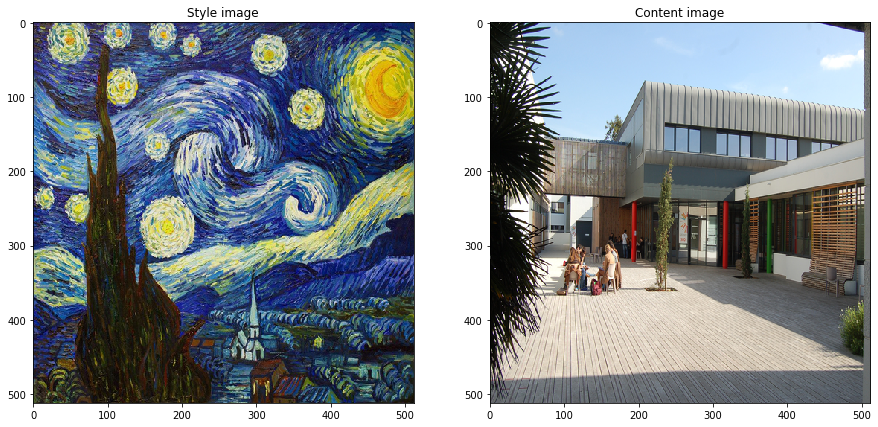

In [4]:
fig = plt.figure(figsize=(15, 10))

axes = fig.add_subplot(1, 2, 1)
axes.imshow(style_img)
axes.set_title("Style image")

axes = fig.add_subplot(1, 2, 2)
axes.imshow(content_img)
axes.set_title("Content image")

plt.show(fig)

## Preprocess images

Images are preprocessed to respect the training input policy of VGG19.

In [5]:
content_img = np.array(content_img)
style_img = np.array(style_img)

In [6]:
content_img = np.expand_dims(content_img, axis=0)
style_img = np.expand_dims(style_img, axis=0)

In [7]:
print(f"Content shape : {content_img.shape}")
print(f"Style shape : {style_img.shape}")

Content shape : (1, 512, 512, 3)
Style shape : (1, 512, 512, 3)


In [8]:
content_img = keras.applications.vgg19.preprocess_input(content_img, mode="tf")
style_img = keras.applications.vgg19.preprocess_input(style_img, mode="tf")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


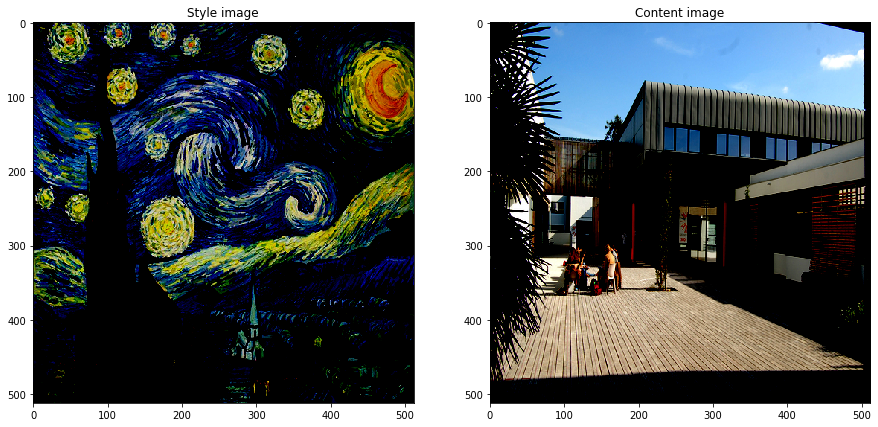

In [9]:
fig = plt.figure(figsize=(15, 10))

axes = fig.add_subplot(1, 2, 1)
axes.imshow(np.squeeze(style_img))
axes.set_title("Style image")

axes = fig.add_subplot(1, 2, 2)
axes.imshow(np.squeeze(content_img))
axes.set_title("Content image")

plt.show(fig)

# Features visualization for content

## Load model

In [10]:
vgg = VGG19(include_top=False,  weights='imagenet', input_shape=IMAGE_SHAPE)
vgg.trainable = False

In [11]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [12]:
def get_vgg_layer(vgg, layer_name: str, model_name: str=None) -> keras.models.Model:
    output = vgg.get_layer(layer_name).output
    return keras.models.Model(vgg.input, output, name=model_name)

In [13]:
block1 = get_vgg_layer(vgg, "block1_conv1", "block1")
block2 = get_vgg_layer(vgg, "block2_conv1", "block2")
block3 = get_vgg_layer(vgg, "block3_conv1", "block3")
block4 = get_vgg_layer(vgg, "block4_conv1", "block4")
block5 = get_vgg_layer(vgg, "block5_conv1", "block5")

blocks = [block1, block2, block3, block4, block5]

In [14]:
block1.summary()

Model: "block1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


## Create loss and gradient function

We want the latent space representation of the input noise to fit the latent space representation of the input image.

### Loss
Let $c_m$ be the features extracted by the model $M$ from the content image $C$, and $x_m$ the features extracted by that same layer of the input noise $X$ :

$L(x_m, c_m) = \frac{1}{2} \sum_i {(x_{m, i} - c_{m, i)}2$

Let $\tilde{X}$ be the reconstructed image based on the features exctracted by $M$ :

$\tilde{X} = \underset{X}{\mathrm{argmin}} ~~ L(M(X), M(C)) =  \underset{X}{\mathrm{argmin}} ~~ L(x_m, c_m)$

In [15]:
def get_features_loss(noise_features, features_target):
    return tf.reduce_mean(tf.square(noise_features - features_target))

In [16]:
def compute_loss(model, init_noise, features):
    model_outputs = model(init_noise)
    return get_features_loss(model_outputs, features) 

In [17]:
def compute_grads(model, init_noise, features):
    with tf.GradientTape() as tape: 
        tape.watch(init_noise) # TOUJOURS REGARDER CE QUI VIENT D'AILLEURS 
        loss = compute_loss(model, init_noise, features)
    return tape.gradient(loss, init_noise), loss # dL(c, x)/dx

## Training function

In [33]:
def train_content_features(block: tf.keras.models.Model, img: np.ndarray, iterations=500, opt=tf.keras.optimizers.Adam(5, decay=1e-3)) -> Tuple[List, np.ndarray]:

    with tf.device("GPU:0"):
        features = block(img)
        init_noise = tf.Variable(tf.random.normal([1, *IMAGE_SHAPE])) #WARNING: toujours mettre les trucs utilisés par le
                                                                      #GradientTape en tf.Variable ("mutable tensor") sinon c'est 
                                                                      #la hez
        min_vals = -1
        max_vals = 1

        history = []
        built_imgs = []
        best_loss = float("inf")


        for i in tqdm(range(iterations), f"Building img for {block.name}"):
            grads, loss = compute_grads(block, init_noise, features)
            opt.apply_gradients([(grads, init_noise)])
            clipped = tf.clip_by_value(init_noise, min_vals, max_vals)
            init_noise.assign(clipped) 

            history.append(loss.numpy())

            if loss < best_loss:
                best_loss = loss
                built_imgs.append(np.squeeze(init_noise.numpy().copy()))
                
    return history, built_imgs

## Train on noise image

In [34]:
results = {}
for block in blocks:
    results[block.name] = train_content_features(block, content_img)

Building img for block5: 100%|██████████| 500/500 [00:37<00:00, 13.17it/s]


Deprocessing based on :

https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py

In [35]:
def deprocess_image(x):
    y = x.copy()
    y += 1.
    y *= 127.5
    return y.astype("uint8")

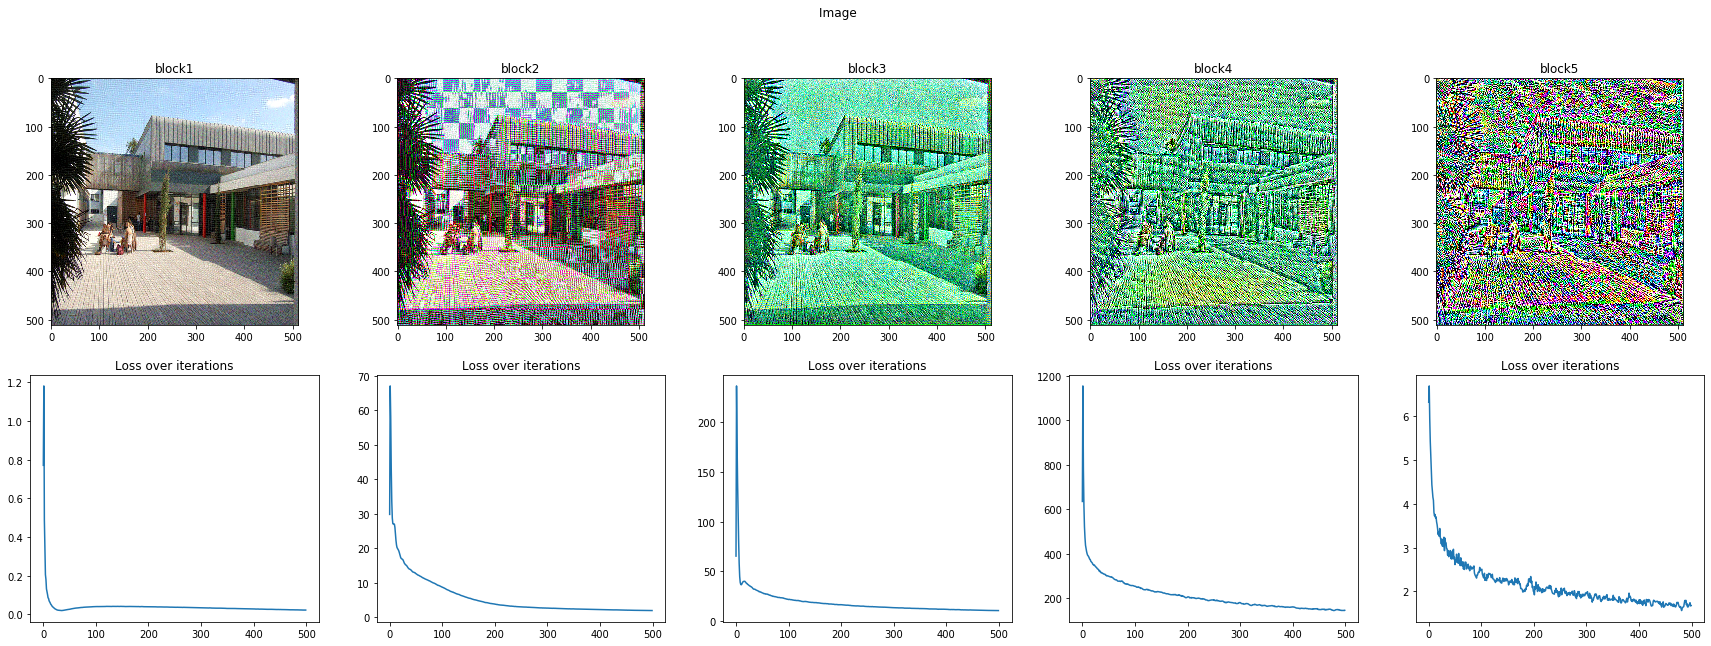

In [36]:
fig = plt.figure(figsize=(30,10))
fig.suptitle("Image ")
for i, block in enumerate(blocks):
    axes = fig.add_subplot(2, len(blocks), i+1)
    axes.imshow(deprocess_image(results[block.name][1][-1]))
    axes.set_title(block.name)
    
    axes2 = fig.add_subplot(2, len(blocks), i+len(blocks)+1)
    axes2.plot(results[block.name][0])
    axes2.set_title("Loss over iterations")

In [38]:
fig.savefig("../reports/content-features-visualization.png")